# import

In [2]:
!pip install mat73

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/GTxPython')

Mounted at /content/drive


In [4]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
import scipy.io as sio
import mat73
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
import tensorflow as tf
from keras.saving import register_keras_serializable

from code_tf.preprocess import *

In [6]:
print("Python:", sys.executable)
print("TF version:", tf.__version__)
print("CUDA built with:", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN built with:", tf.sysconfig.get_build_info().get("cudnn_version"))

Python: /usr/bin/python3
TF version: 2.19.0
CUDA built with: 12.5.1
cuDNN built with: 9


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(gpus)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# model

## unzip model

In [34]:
# !tar -xvzf /content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad10/model.tar.gz -C /content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad10/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
loss.log
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
model.keras


## test model

In [8]:
@register_keras_serializable(package="metrics_losses")
class TumorMAE(tf.keras.metrics.Metric):
    def __init__(self, depth_padding=10.0, name="tumor_mae", **kwargs):
        super().__init__(name=name, **kwargs)
        self.depth_padding = depth_padding
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.not_equal(y_true, self.depth_padding)
        err  = tf.abs(y_true - y_pred)
        masked_err = tf.boolean_mask(err, mask)
        value = tf.cond(
            tf.size(masked_err) > 0,
            lambda: tf.reduce_mean(masked_err),
            lambda: tf.constant(0.0)
        )
        self.total.assign_add(value)
        self.count.assign_add(1.0)

    def result(self):
        return self.total / self.count

In [9]:
def test_load_model(model_path):
    model = keras.models.load_model(model_path, safe_mode=True)

    input_1 = tf.constant(np.ones((1, 101, 101, 2), dtype=np.float32))
    input_2 = tf.constant(np.ones((1, 101, 101, 6, 1), dtype=np.float32))

    output = model([input_1, input_2], training=False)

    print(output[0].shape)
    print(output[1].shape)

In [10]:
test_load_model("/content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad20/model.keras")

(1, 101, 101)
(1, 101, 101)


# utils

In [11]:
def draw_pred(gt_depth, pred_depth):
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  v_min = min(np.min(gt_depth), np.min(pred_depth))
  v_max = max(np.max(gt_depth), np.max(pred_depth))
  im0 = ax[0].imshow(gt_depth, cmap='viridis', vmin=v_min, vmax=v_max)
  ax[0].set_title('Ground Truth')
  ax[1].imshow(pred_depth, cmap='viridis', vmin=v_min, vmax=v_max)
  ax[1].set_title('Prediction')
  im2 = ax[2].imshow(gt_depth - pred_depth, cmap='Purples')
  ax[2].set_title('Difference')
  cbar = fig.colorbar(im0, ax=ax[0:2], orientation='vertical')
  cbar.set_label('Depth')
  cbar_err = fig.colorbar(im2, ax=ax[2], orientation='vertical')
  cbar_err.set_label('Error')
  plt.show()

# predict

## on simulated data

In [12]:
scale_params = {
    'fluorescence': 10e4,
    'mu_a': 10,
    'mu_s': 1,
    'depth': 1,
    'concentration_fluor': 1,
    'reflectance': 1,
}
file_path = "/content/drive/MyDrive/GTxPython/data/finalized/ts_2d_10000_original_TBR.mat"
test_data = load_data(file_path, scale_params, 888, 0)

FFFFF: [(np.float32(1.5005018e-07), np.float32(0.0022840023)), (np.float32(2.768177e-08), np.float32(0.001968136)), (np.float32(9.098925e-09), np.float32(0.0015638856)), (np.float32(3.6914662e-09), np.float32(0.0014251228)), (np.float32(3.0505463e-09), np.float32(0.0012524473)), (np.float32(2.5957803e-09), np.float32(0.001083783))]
OOOOO: [(np.float32(0.000958141), np.float32(0.032059222)), (np.float32(0.72761714), np.float32(2.0806746))]


In [30]:
def try_pred(model, test_data, draw=False, depth_padding=10.0, device='cpu', batch=1):
    if device == "auto":
        device_str = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
    elif device.lower() == "gpu":
        device_str = "/GPU:0"
    elif device.lower() == "cpu":
        device_str = "/CPU:0"
    else:
        device_str = device

    tt_data = test_data['test']
    N = len(tt_data["depth"])
    idx_all = list(range(0, N))

    acc_err = 0
    acc_count = 0

    for b_start in tqdm(range(0, len(idx_all), batch)):
        b_end = min(b_start + batch, len(idx_all))
        batch_idx = idx_all[b_start:b_end]

        fl = tt_data['fluorescence'][batch_idx, ...]
        mu_a = tt_data['mu_a'][batch_idx, ...]
        mu_s = tt_data['mu_s'][batch_idx, ...]
        op = np.stack([mu_a, mu_s], axis=-1)
        conc_fluor = tt_data['concentration_fluor'][batch_idx, ...]
        reflectance = tt_data['reflectance'][batch_idx, ...]
        depth = tt_data['depth'][batch_idx, ...]
        depth[depth==0] = depth_padding


        input1 = tf.convert_to_tensor(op, dtype=tf.float32)
        input2 = tf.convert_to_tensor(fl, dtype=tf.float32)

        outputs = model([input1, input2], training=False)
        pred_conc = outputs[0].numpy()
        pred_depth = outputs[1].numpy()

        for k in range(len(batch_idx)):
            idx = batch_idx[k]
            gt = depth[k].copy()
            p = pred_depth[k].copy()
            max_gt = np.max(gt[gt!=depth_padding])

            if max_gt < depth_padding:
                p[p>max_gt]=0
            else:
                p[(p >= depth_padding-0.5) & (p <= depth_padding+0.5)]=0
            gt[gt==depth_padding]=0
            draw_pred(gt, p) if draw else None

            difference_map = np.abs(gt - p)
            mean_nonBG = np.mean(difference_map[difference_map != 0])
            print(f"Mean difference: {mean_nonBG}") if draw else None

            acc_err += np.sum(difference_map[difference_map != 0])
            acc_count += (difference_map != 0).sum()

    return acc_err / acc_count
#

  0%|          | 0/125 [00:00<?, ?it/s]

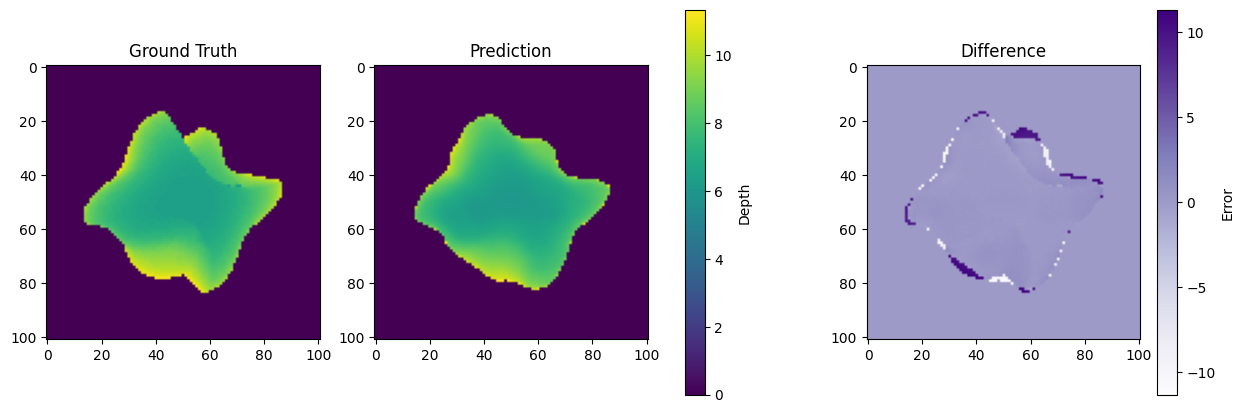

  0%|          | 0/125 [00:00<?, ?it/s]

Mean difference: 0.899894654750824


In [31]:
model = keras.models.load_model("/content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad20/model.keras", safe_mode=True)
try_pred(model, test_data, draw=True, depth_padding=20.0, device='gpu', batch=8)

  0%|          | 0/125 [00:00<?, ?it/s]

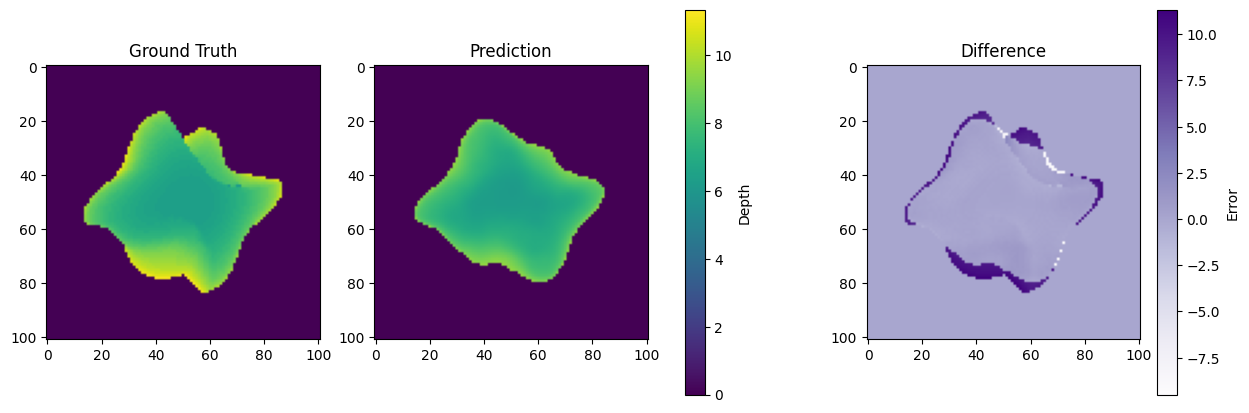

  0%|          | 0/125 [00:00<?, ?it/s]

Mean difference: 1.3766800165176392


In [33]:
model = keras.models.load_model("/content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad10/model.keras", safe_mode=True)
try_pred(model, test_data, draw=True, depth_padding=10.0, device='gpu', batch=8)

In [15]:
model = keras.models.load_model("/content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad20/model.keras", safe_mode=True)
try_pred(model, test_data, draw=False, depth_padding=20.0, device='gpu', batch=8)

100%|██████████| 125/125 [00:29<00:00,  4.18it/s]


np.float64(1.0650218867206571)

In [16]:
model = keras.models.load_model("/content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad10/model.keras", safe_mode=True)
try_pred(model, test_data, draw=False, depth_padding=10.0, device='gpu', batch=8)

100%|██████████| 125/125 [00:27<00:00,  4.60it/s]


np.float64(2.0246821790362897)

## phantom data

In [17]:
def load_phantom_data(path):
    def scale_data(data_dict, params):
        scaled_data_dict = {}
        for key, items in data_dict.items():
            if key != "optical_props" and key != "op":
                scaled_data_dict[key] = items * params[key]
        return scaled_data_dict

    data = sio.loadmat(path)
    fluorescence = data['fluorescence']
    optical_props = data['optical_props']
    depth = data['depth']
    concentration_fluor = data['concentration_fluor']
    reflectance = data['reflectance']

    output = {
        'fluorescence': fluorescence,
        'reflectance': reflectance,
        'depth': depth,
        'mu_a': optical_props[..., 0],
        'mu_s': optical_props[..., 1],
        'concentration_fluor': concentration_fluor
    }

    return scale_data(output, scale_params)

path = '/content/drive/MyDrive/GTxPython/data/phantom/phantom_data_corrected.mat'
phantom_data = load_phantom_data(path)

In [41]:
from skimage.filters import threshold_otsu
def pred_phantom_1(model, phantom_data, idx, draw=False, depth_padding=10.0):
    fl = phantom_data['fluorescence'][[idx], ...]
    mua = phantom_data['mu_a'][[idx], ...]
    mus = phantom_data['mu_s'][[idx], ...]
    op = np.stack([mua, mus], axis=-1)
    conc_fluor = phantom_data['concentration_fluor'][[idx], ...]
    reflectance = phantom_data['reflectance'][[idx], ...]
    depth = phantom_data['depth'][[idx], ...]
    depth[depth==0] = depth_padding

    input1 = tf.convert_to_tensor(op, dtype=tf.float32)
    input2 = tf.convert_to_tensor(fl, dtype=tf.float32)

    outputs = model([input1, input2], training=False)

    pred_conc = outputs[0].numpy()
    pred_depth = outputs[1].numpy()

    thresh = threshold_otsu(pred_depth[0])
    mask = pred_depth[0] < thresh
    masked_img = np.where(mask, pred_depth[0], 0)

    gt = depth[0].copy()
    gt[gt==depth_padding]=0
    max_gt = np.max(gt[gt!=depth_padding])
    p = masked_img.copy()

    depth_arr = depth[0].flatten()
    pred_depth_arr = pred_depth[0].flatten()

    min_gt_value = np.min(depth_arr)
    min_gt_px = np.argmin(depth_arr)
    min_pred_value = np.min(pred_depth_arr)
    min_pred_px = np.argmin(pred_depth_arr)
    err_min = np.abs(min_gt_value-min_pred_value)
    print(f"Diff： {err_min}") if draw else None

    draw_pred(gt, masked_img) if draw else None

    return err_min


Diff： 1.4982792139053345


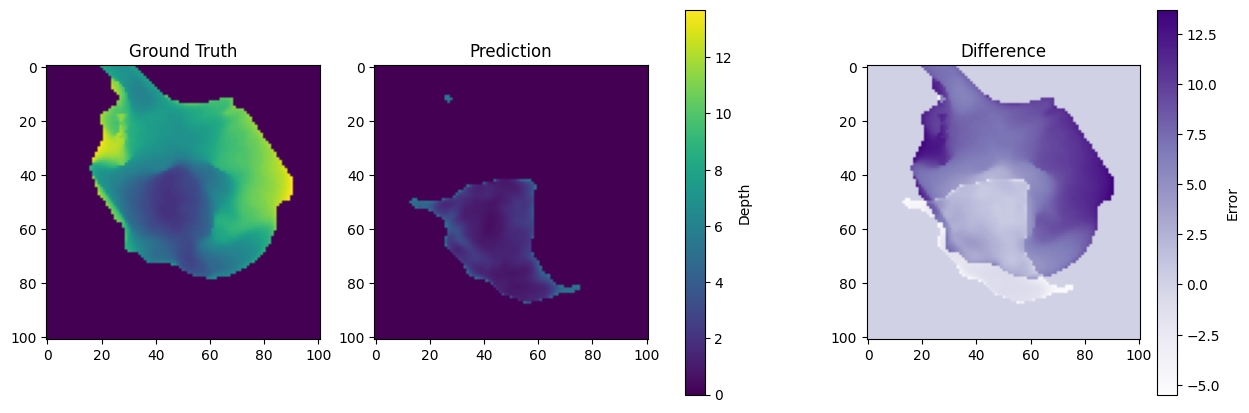

Diff： 3.744696617126465


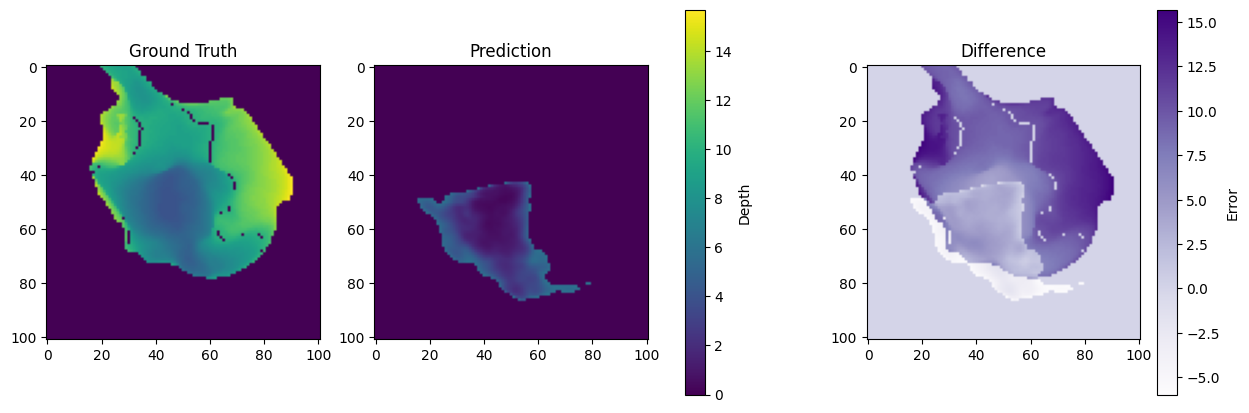

Diff： 2.842805862426758


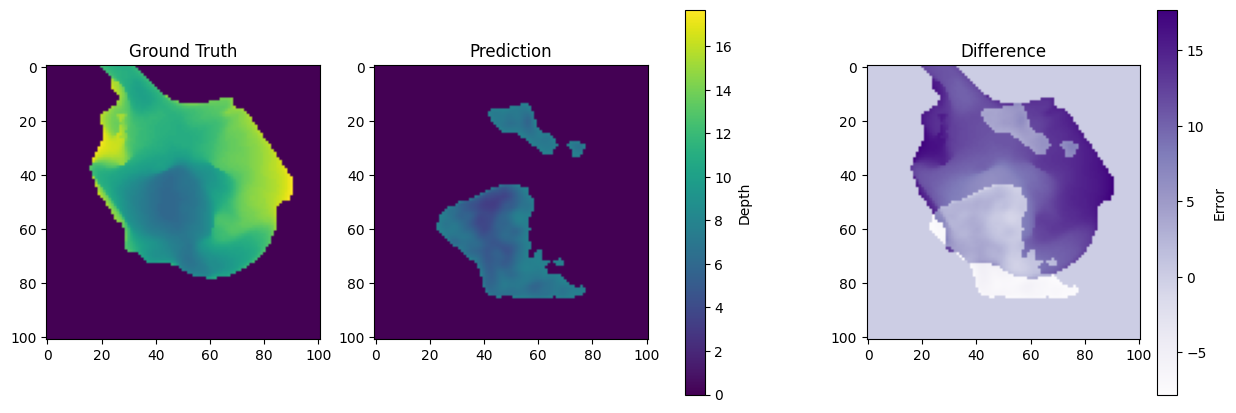

Diff： 1.6876873970031738


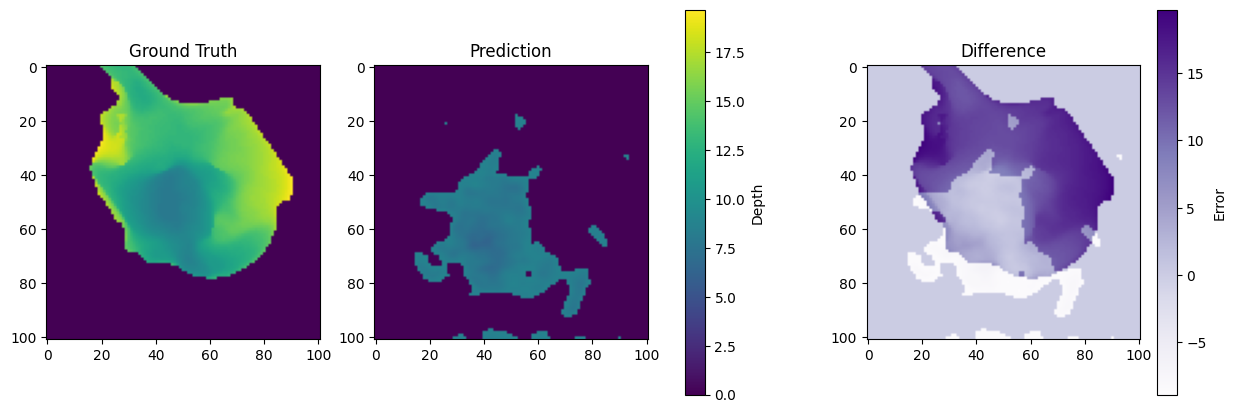

Diff： 1.6668139696121216


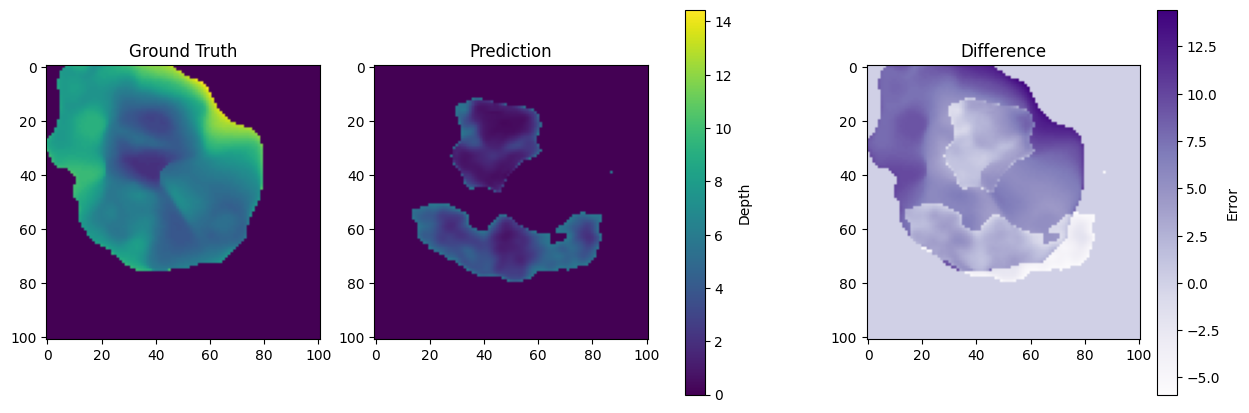

Diff： 2.944040298461914


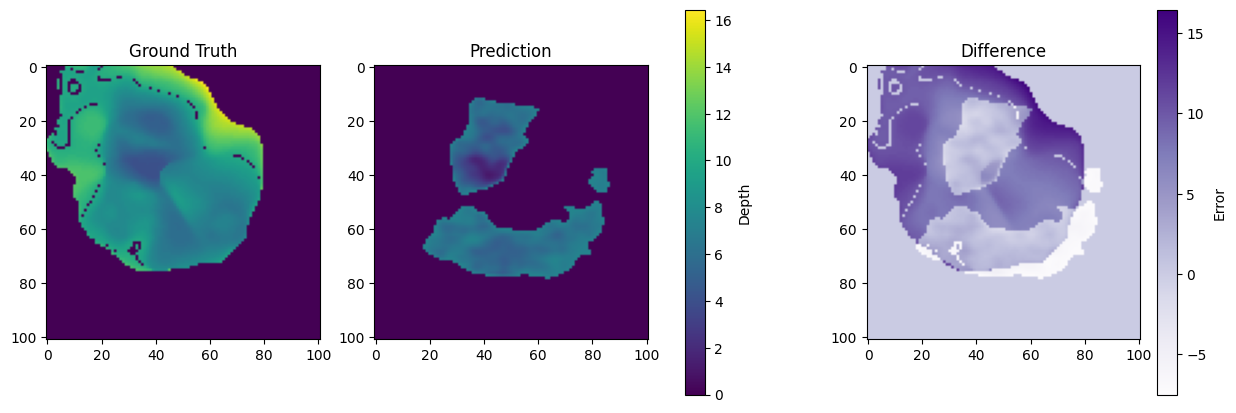

Diff： 0.8253421783447266


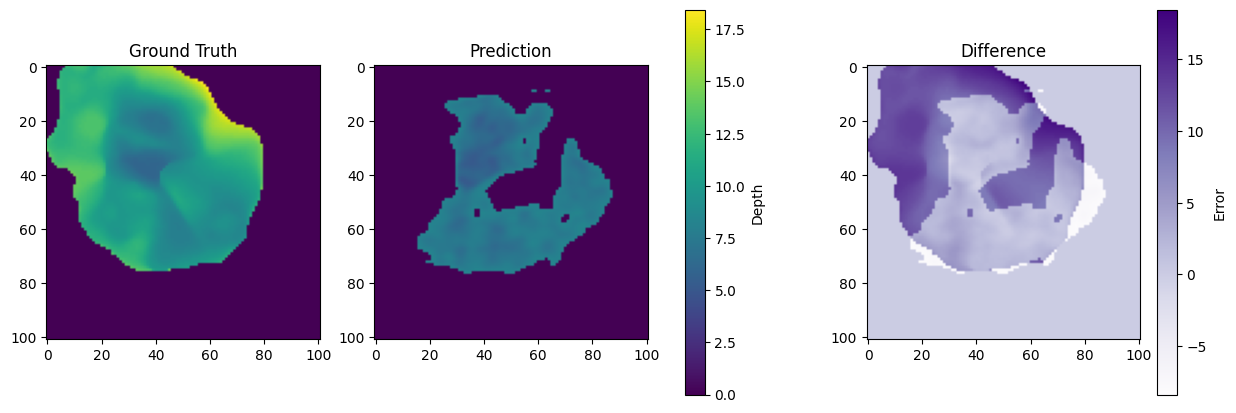

Diff： 1.076826572418213


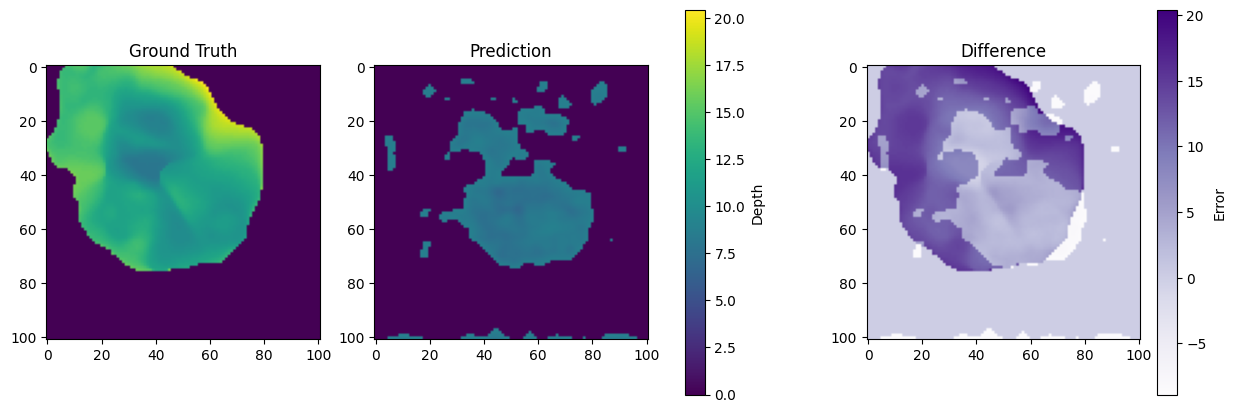

Diff： 1.5571779012680054


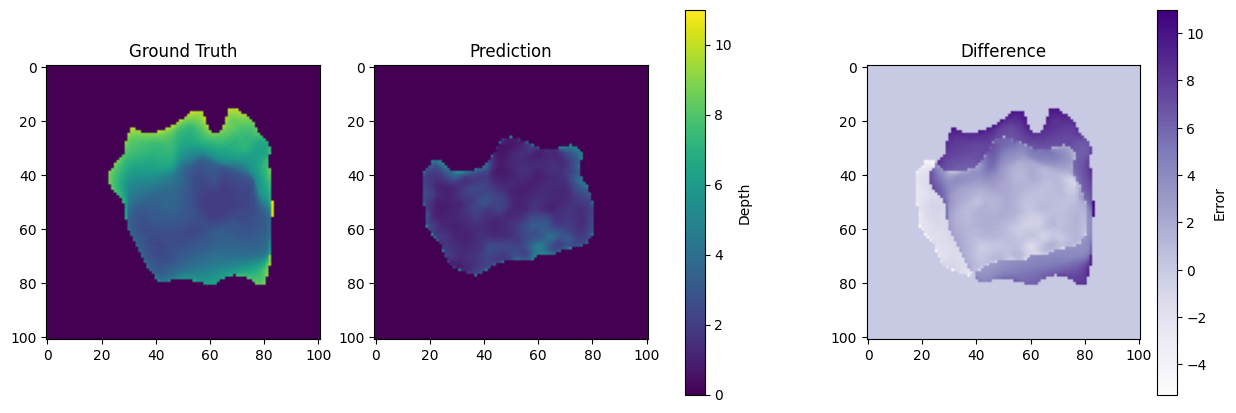

Diff： 7.66722297668457


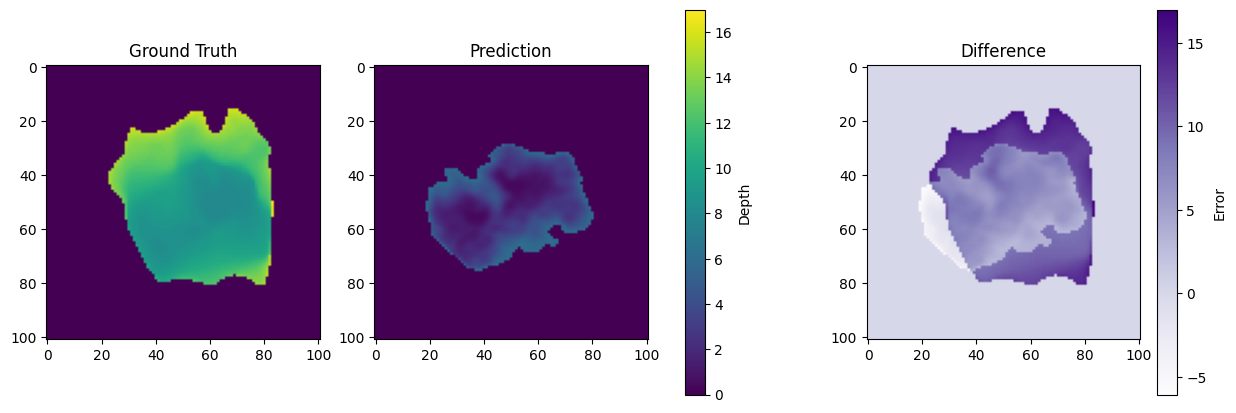

Diff： 3.1248154640197754


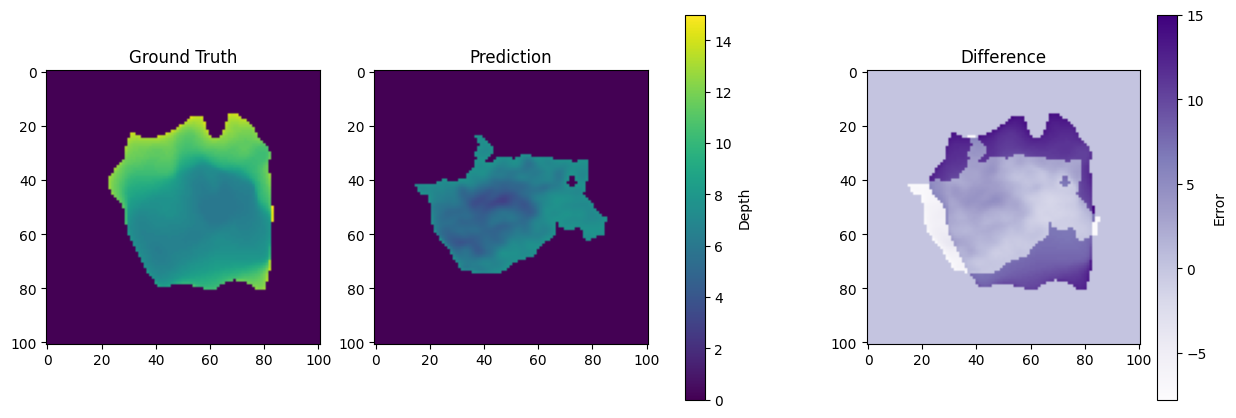

Diff： 1.6292290687561035


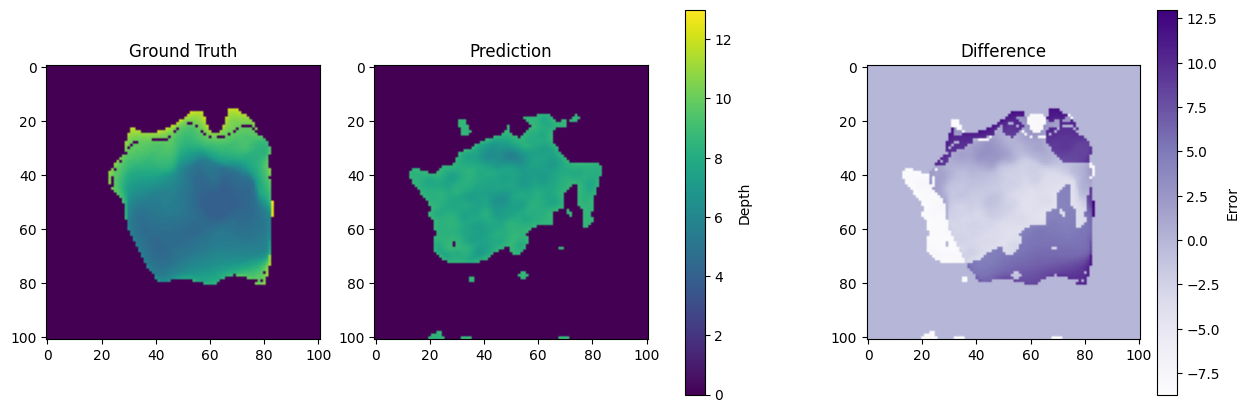

Diff： 1.7240439653396606


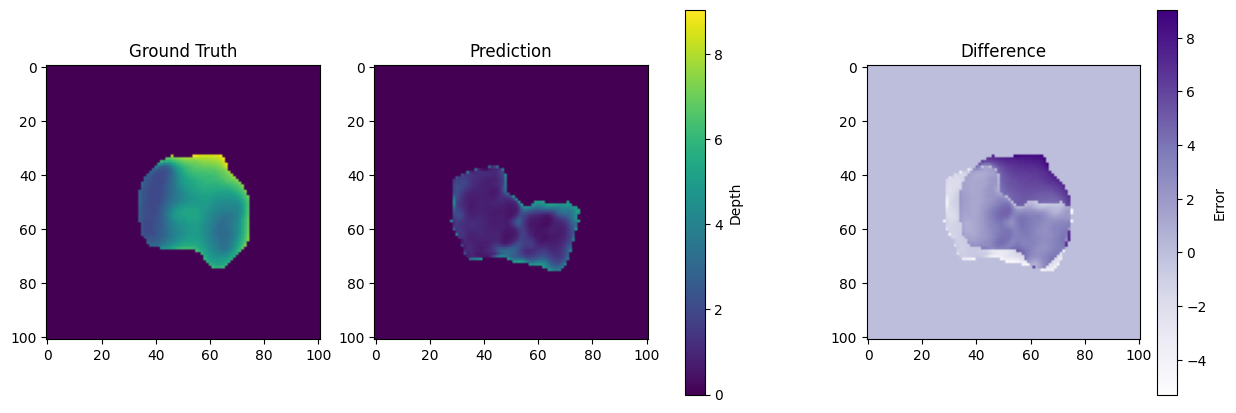

Diff： 3.6245245933532715


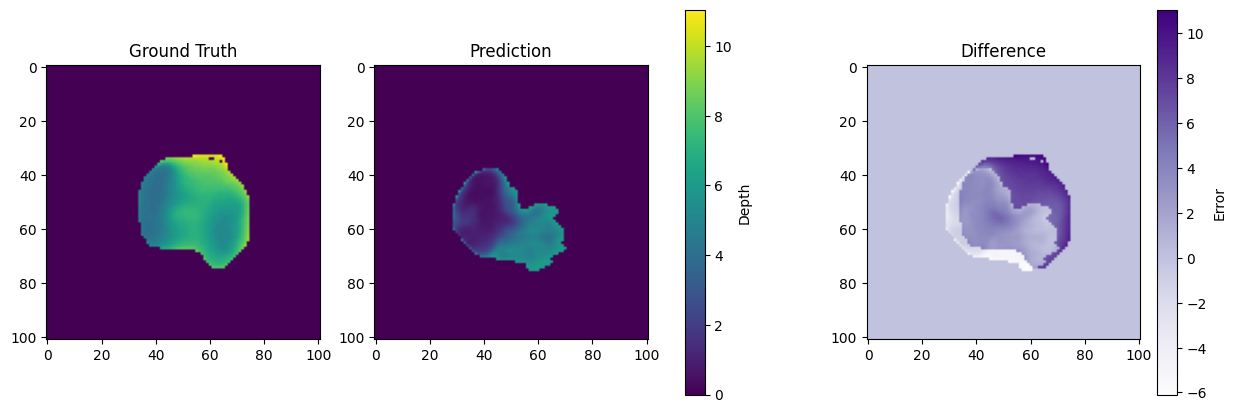

Diff： 3.0826468467712402


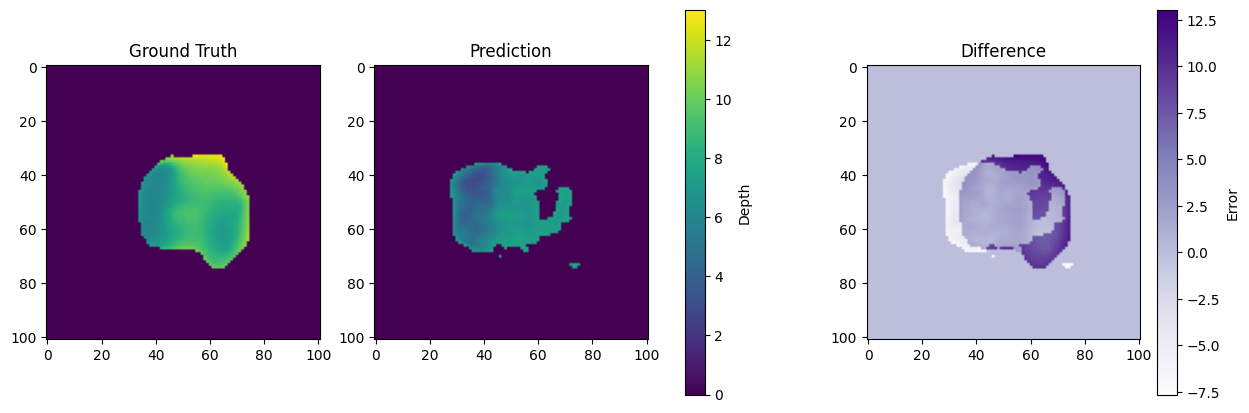

Diff： 3.4433422088623047


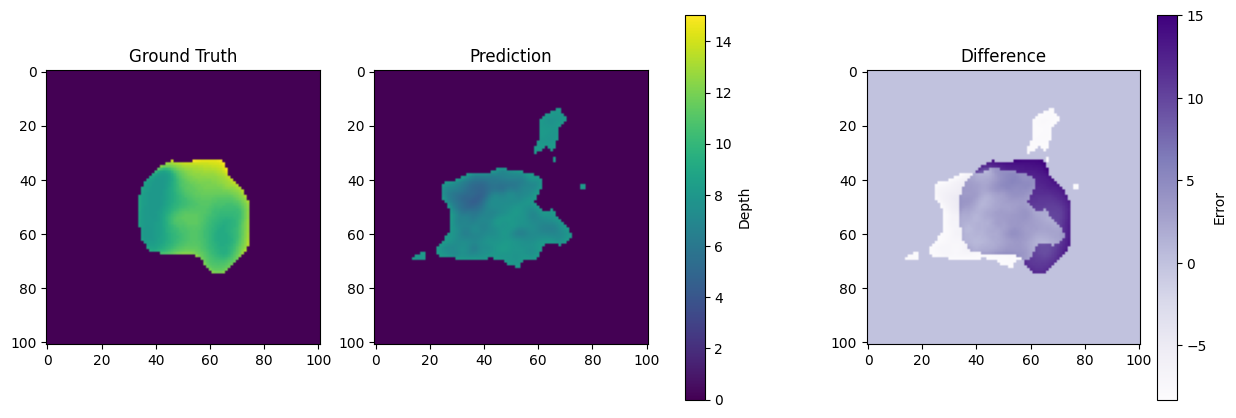

Diff： 1.5449187755584717


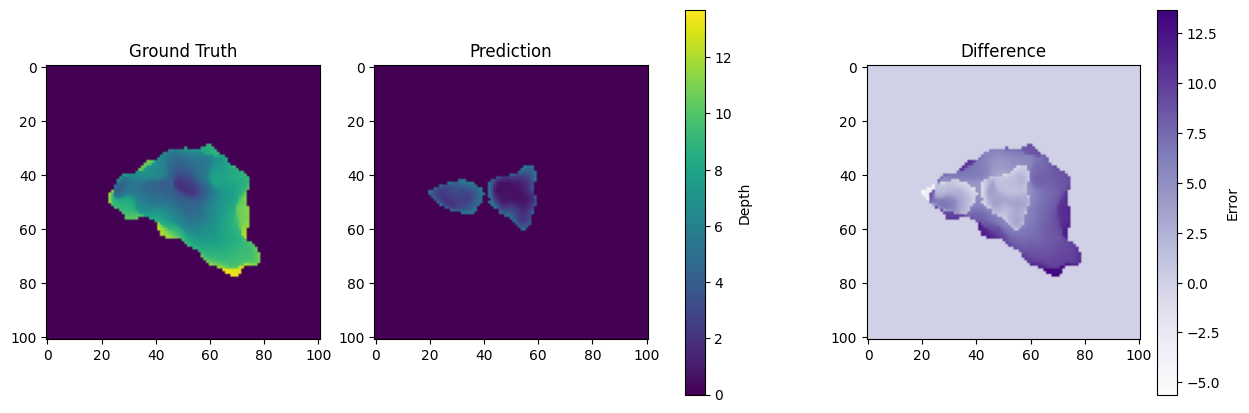

Diff： 2.4993515014648438


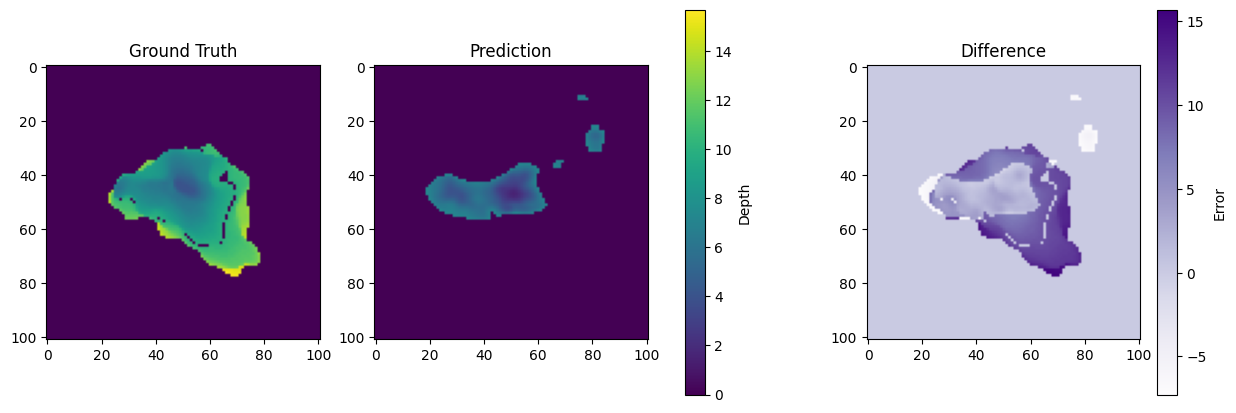

Diff： 1.6283984184265137


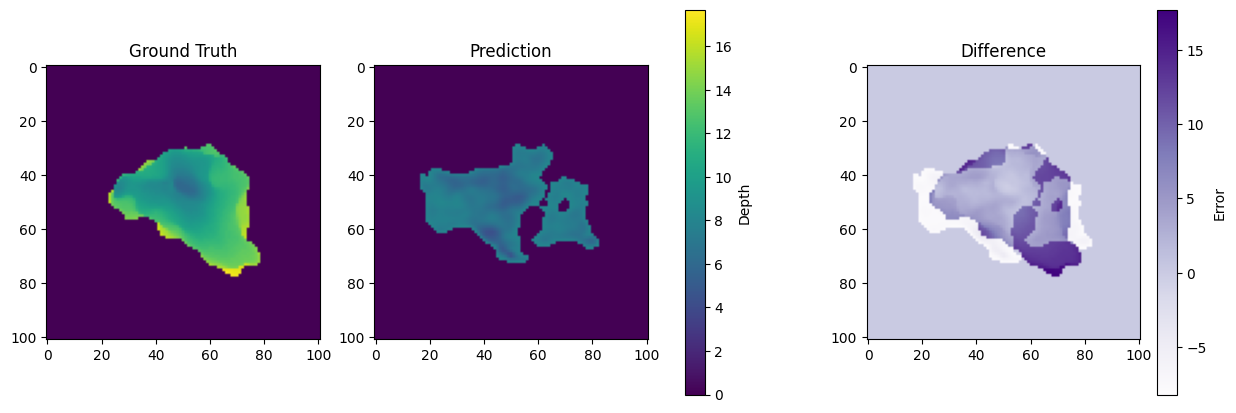

Diff： 1.1895136833190918


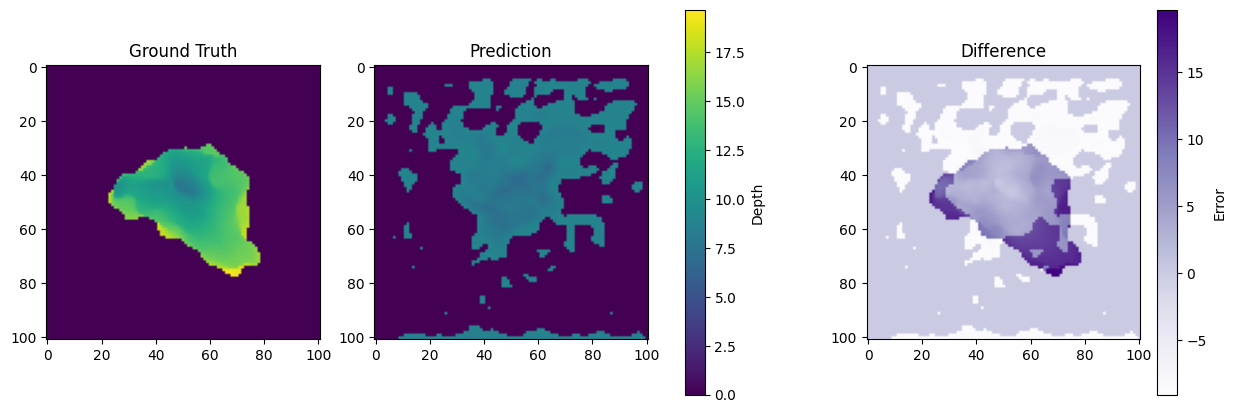

Diff： 1.5358526706695557


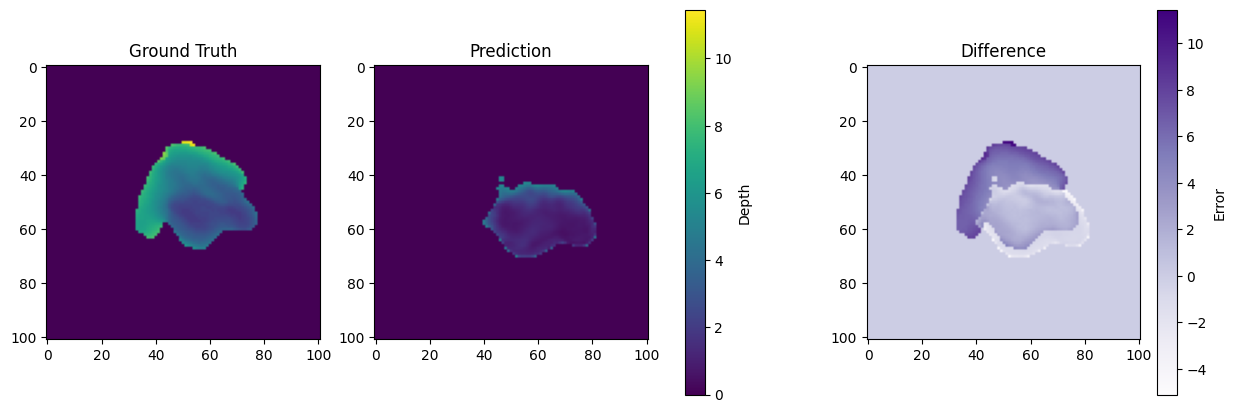

Diff： 1.0613679885864258


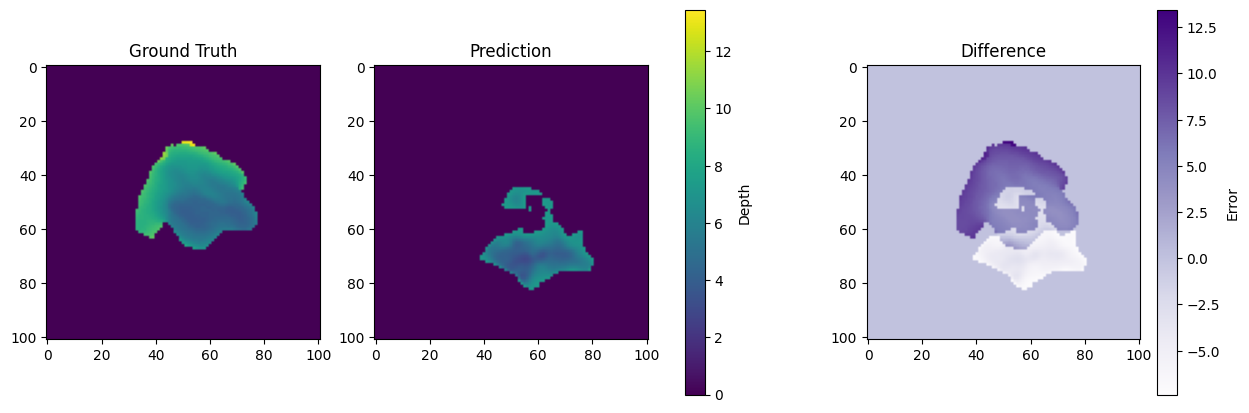

Diff： 1.1372079849243164


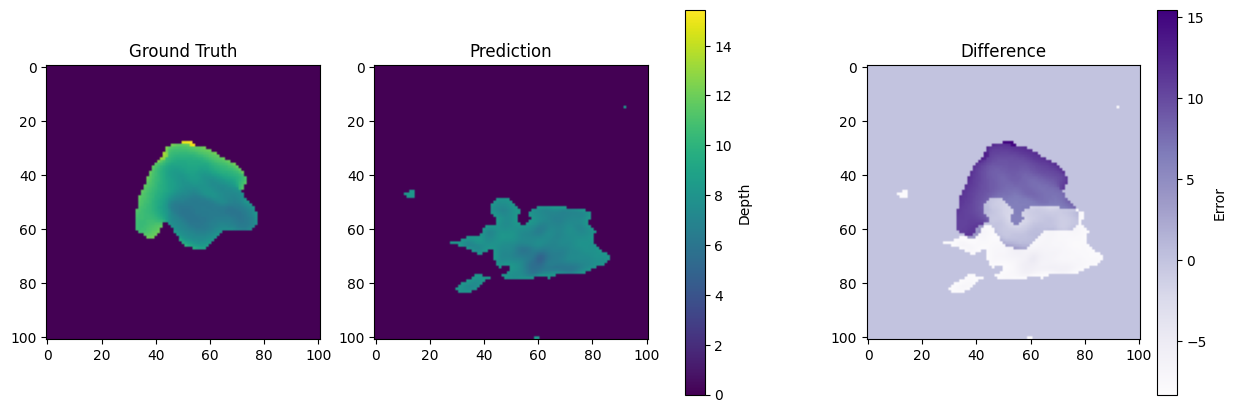

Diff： 1.1843924522399902


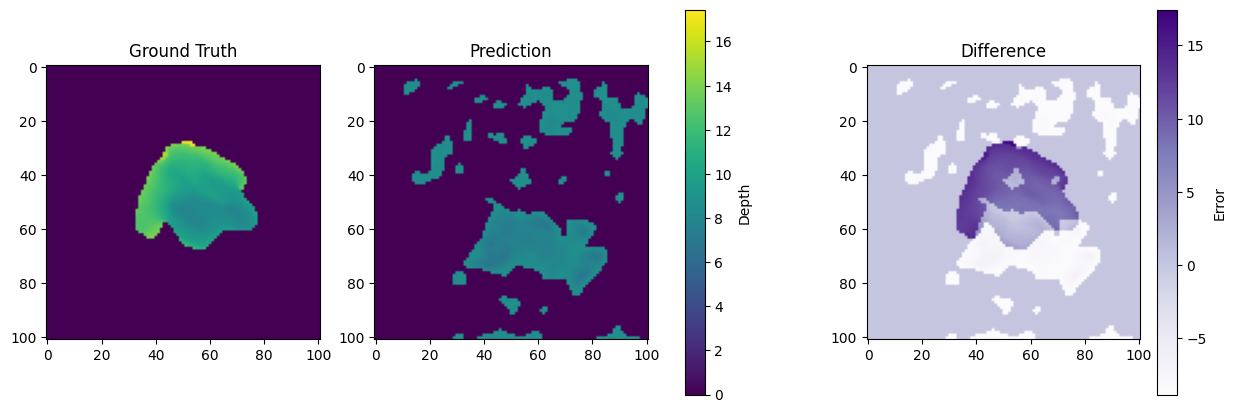

Diff： 2.1366310119628906


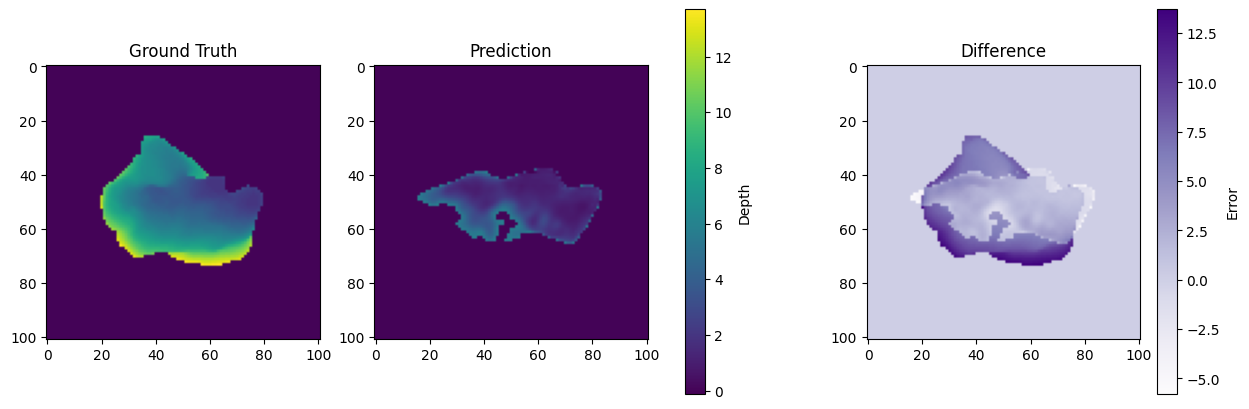

Diff： 3.2439992427825928


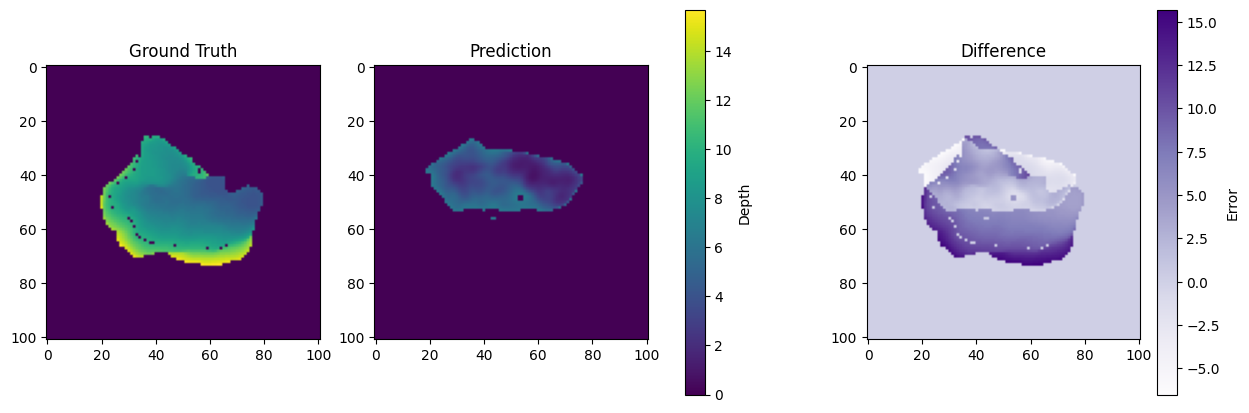

Diff： 0.35796499252319336


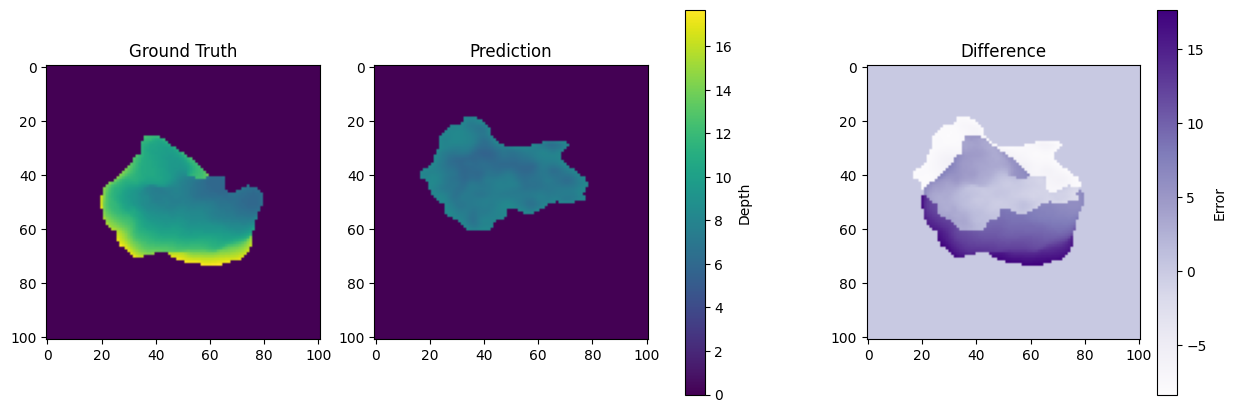

Diff： 1.6900601387023926


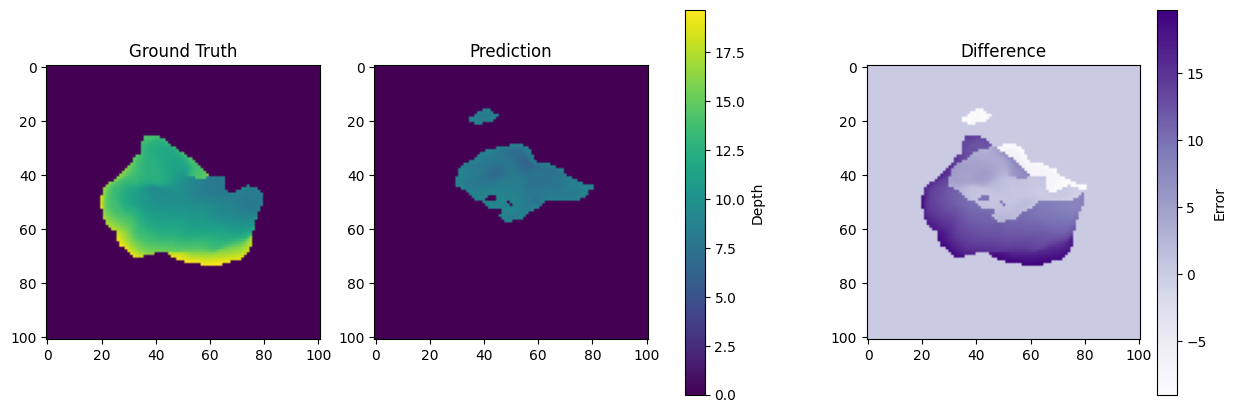

Diff： 1.2549809217453003


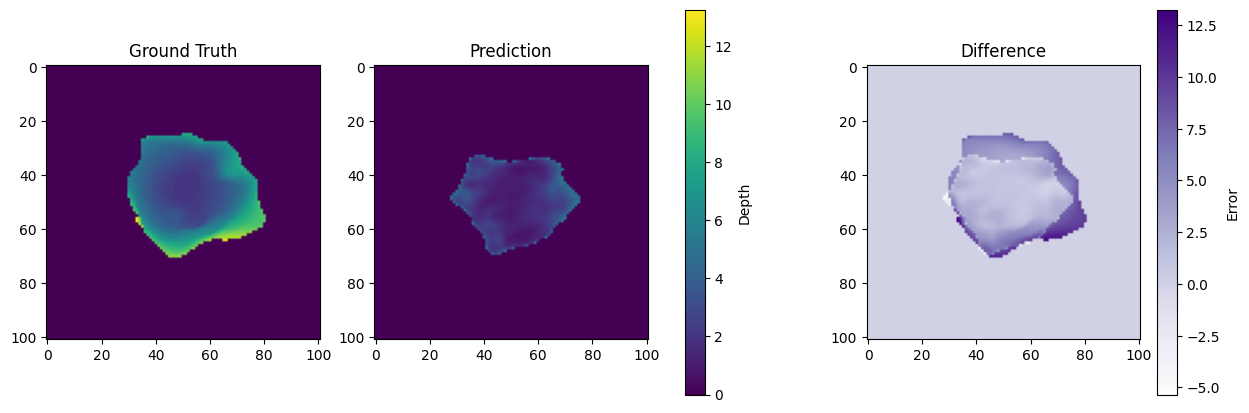

Diff： 2.047977924346924


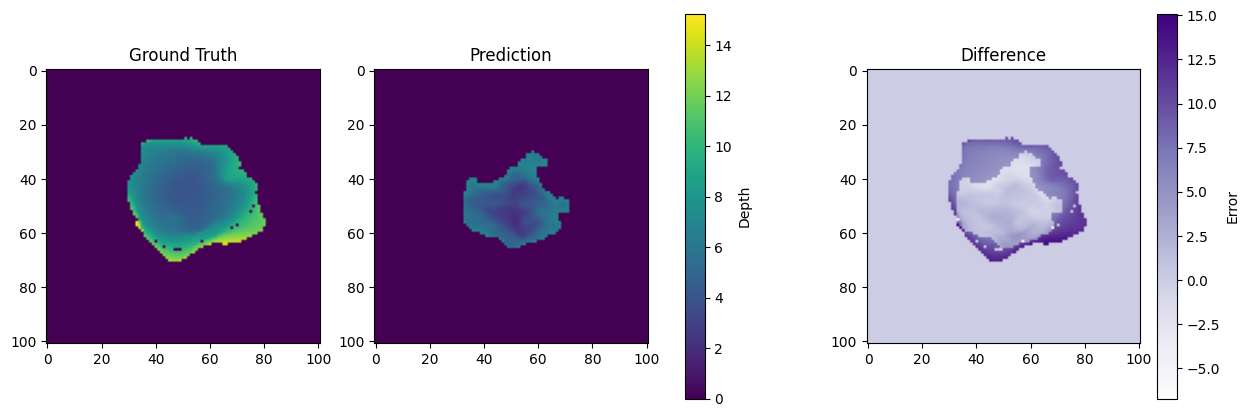

Diff： 0.985929012298584


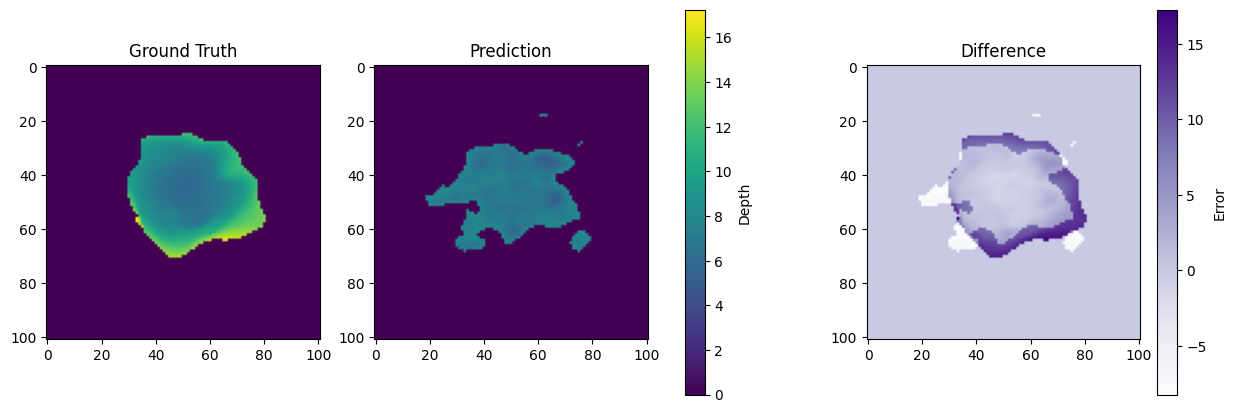

Diff： 1.9534697532653809


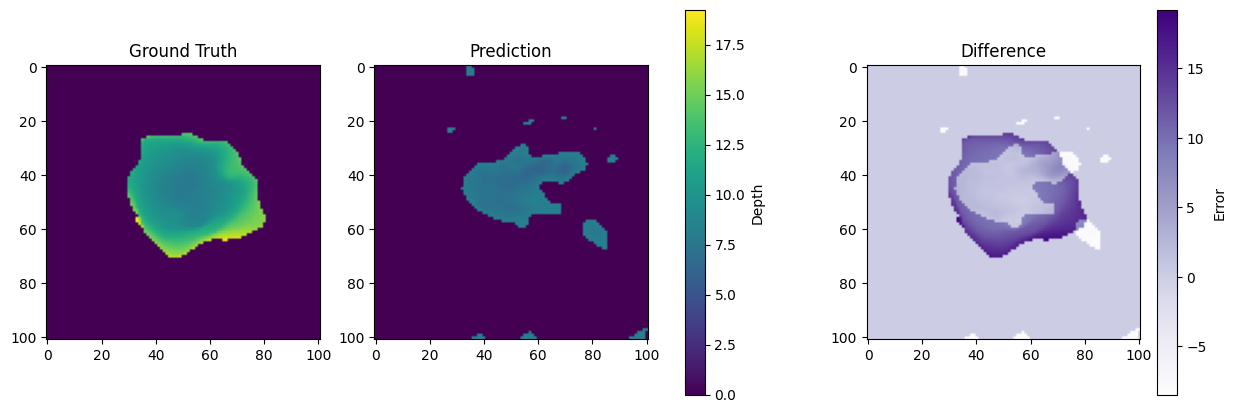

Diff： 1.972095251083374


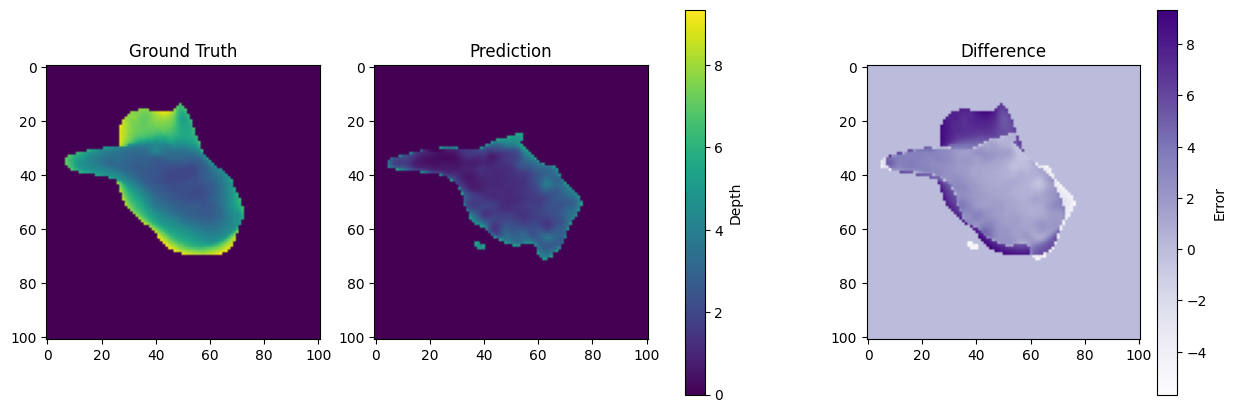

Diff： 2.1517510414123535


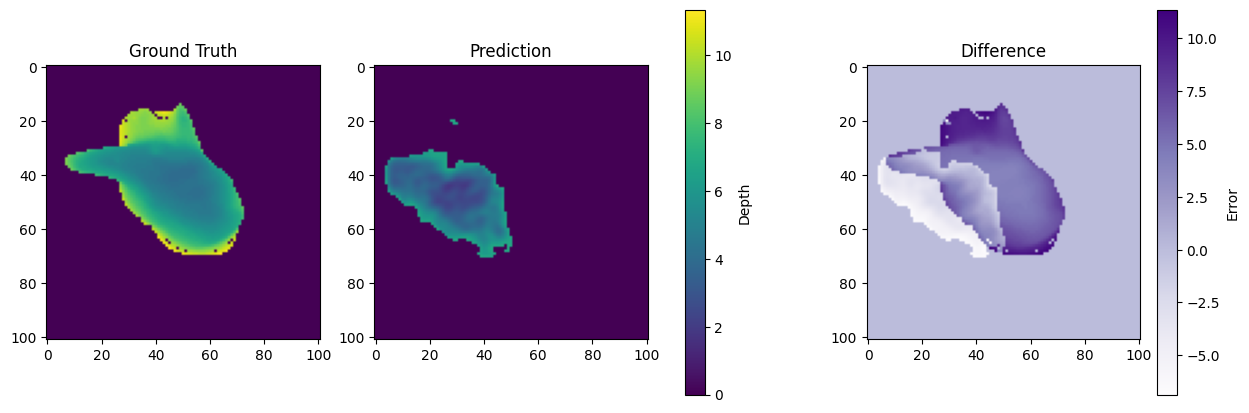

Diff： 0.052475929260253906


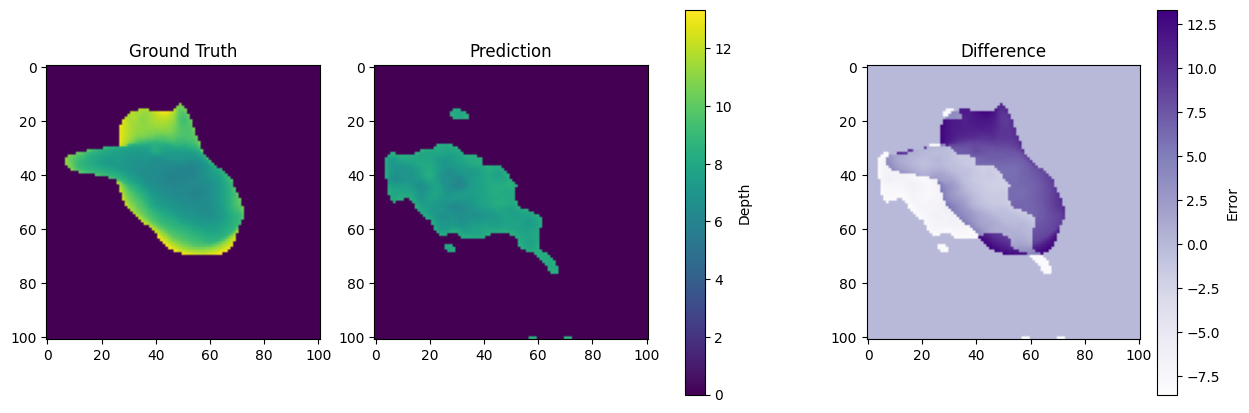

Diff： 1.6128535270690918


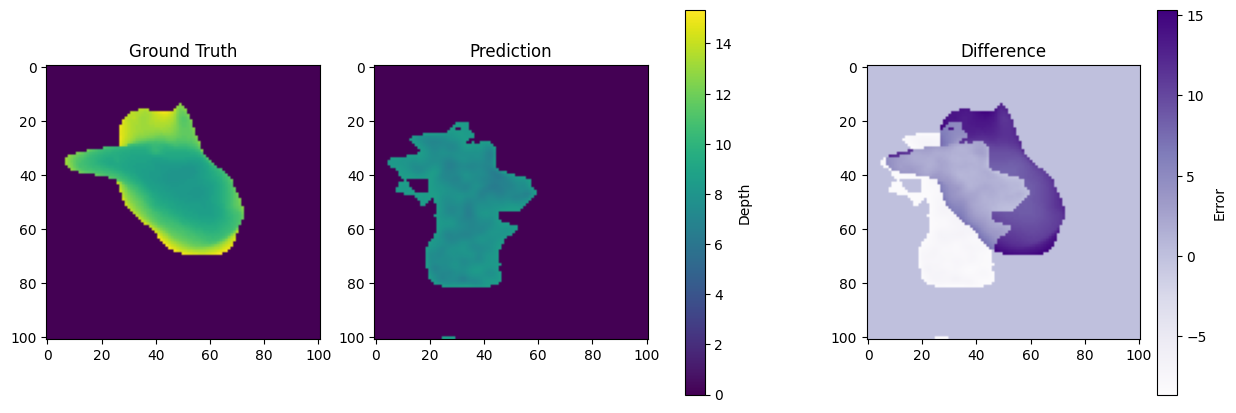

np.float32(2.0383523)

In [42]:
def try_pred_on_phantom(model, phantom_data, draw=False, depth_padding=10.0, mm_pred=None):
    err_min_sum = 0
    err_min_count = 0
    for i in range(len(phantom_data['fluorescence'])):
        err_min = pred_phantom_1(model, phantom_data, i, draw=draw, depth_padding=depth_padding)
        err_min_sum += err_min
        err_min_count += 1

    return err_min_sum / err_min_count

model = keras.models.load_model("/content/drive/MyDrive/GTxPython/new_ckpt_unet/hikaru_2d_pad10/model.keras", safe_mode=True)
try_pred_on_phantom(model, phantom_data, draw=False, depth_padding=10.0, mm_pred=None)